
Media performance demo — интерактивный дашборд для оценки эффективности медиаканалов и кампаний на основе исторических данных.

**Описание**

Этот блок подготавливает окружение для анализа: подключаются библиотеки для работы с данными (pandas, numpy), визуализации (seaborn, matplotlib) и построения моделей машинного обучения (sklearn). Здесь задаются базовые настройки отображения числовых данных и стиля графиков, которые будут использоваться во всех последующих визуализациях и моделях.

**Input:**  
– Исторические данные по кампаниям (затраты, показы, клики, конверсии, ROI и др.) из внешних источников (CSV/таблицы).

**Output:**  
– Готовое окружение для анализа, визуализации и построения ML‑моделей (настроенные библиотеки, стиль графиков, формат отображения чисел).

In [23]:
# Подключение библиотек и базовая настройка окружения
# - импорт: pandas, numpy, seaborn, matplotlib, модули sklearn для ML‑моделей
# - настройка: стиль графиков seaborn и формат вывода чисел в pandas
# - input: нет (используются только установленные библиотеки)
# - output: готовое окружение для последующей загрузки данных, анализа и моделирования

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

OUT_DIR = "out"
os.makedirs(OUT_DIR, exist_ok=True)

sns.set(style="whitegrid")
pd.set_option("display.float_format", lambda x: f"{x:,.3f}")

In [24]:
# Data loading and preprocessing (feature engineering for the dashboard)
# - read CSV with historical media campaign data
# - clean columns, convert types and create additional features (CTR, Engagement_Rate, Duration_days)
# - input: file data/Social_Media_Advertising.csv
# - output: cleaned dataframes df and df_ml ready for analysis and modeling

# Load and clean
DATA_PATH = "data/Social_Media_Advertising.csv"

df = pd.read_csv(DATA_PATH)
df = df.drop(columns=["Company"], errors="ignore")

df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df["Acquisition_Cost"] = df["Acquisition_Cost"].replace("[$,]", "", regex=True).astype(float)
df["Duration_days"] = df["Duration"].str.extract(r"(\d+)").astype(float)

# Engagement metrics
df["CTR"] = np.where(df["Impressions"] > 0, df["Clicks"] / df["Impressions"], np.nan)
df["Engagement_Rate"] = np.where(
    df["Impressions"] > 0,
    df["Engagement_Score"] / df["Impressions"],
    np.nan,
)

df_ml = df.copy()
df.head()

,Campaign_ID,Target_Audience,Campaign_Goal,Duration,Channel_Used,Conversion_Rate,Acquisition_Cost,ROI,Location,Language,Clicks,Impressions,Engagement_Score,Customer_Segment,Date,Duration_days,CTR,Engagement_Rate
0,529013,Men 35-44,Product Launch,15 Days,Instagram,0.150,500.000,5.790,Las Vegas,Spanish,500,3000,7,Health,2022-02-25,15.000,0.167,0.002
1,275352,Women 45-60,Market Expansion,15 Days,Facebook,0.010,500.000,7.210,Los Angeles,French,500,3000,5,Home,2022-05-12,15.000,0.167,0.002
2,692322,Men 45-60,Product Launch,15 Days,Instagram,0.080,500.000,0.430,Austin,Spanish,500,3000,9,Technology,2022-06-19,15.000,0.167,0.003
3,675757,Men 25-34,Increase Sales,15 Days,Pinterest,0.030,500.000,0.910,Miami,Spanish,293,1937,1,Health,2022-09-08,15.000,0.151,0.001
4,535900,Men 45-60,Market Expansion,15 Days,Pinterest,0.130,500.000,1.423,Austin,French,293,1937,1,Home,2022-08-24,15.000,0.151,0.001


In [25]:
# ROI prediction model (core ML block of the dashboard)
# Trains a gradient boosting regression model (HistGradientBoostingRegressor)
# to predict ROI based on media metrics and campaign attributes.
# - input: df_ml with numeric_plus and cat_cols feature lists
# - output: trained model stored in models and new column ROI_pred in df_ml

# Train ROI model (used for ranking, forecast, budget advice)
numeric_features = [
    "Impressions",
    "Clicks",
    "Engagement_Score",
    "Acquisition_Cost",
    "ROI",
    "Conversion_Rate",
]

categorical_features = [
    "Channel_Used",
    "Target_Audience",
    "Customer_Segment",
    "Location",
    "Language",
]

numeric_plus = numeric_features + (["Duration_days"] if "Duration_days" in df_ml.columns else [])
cat_cols = categorical_features
models = {}


def run_boosted(target_col, log_target=True, clip_01=False):
    blocked = {target_col, f"log_{target_col}"}
    feature_cols = [c for c in numeric_plus + cat_cols if c not in blocked]

    X = df_ml[feature_cols]
    y = df_ml[target_col]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Optional log-transform of the target to stabilize variance
    y_train_tr = np.log1p(y_train) if log_target else y_train

    # Preprocessing: impute missing values and one‑hot encode categoricals
    pre = ColumnTransformer(
        [
            (
                "num",
                Pipeline([("imputer", SimpleImputer(strategy="median"))]),
                [c for c in numeric_plus if c not in blocked],
            ),
            (
                "cat",
                Pipeline(
                    [
                        ("imputer", SimpleImputer(strategy="most_frequent")),
                        ("onehot", OneHotEncoder(handle_unknown="ignore")),
                    ]
                ),
                cat_cols,
            ),
        ]
    )

    # Core ML model
    model = HistGradientBoostingRegressor(
        max_depth=10,
        learning_rate=0.07,
        max_iter=400,
        l2_regularization=0.8,
        random_state=42,
        early_stopping=True,
        validation_fraction=0.15,
    )

    pipe = Pipeline([("pre", pre), ("hgb", model)])
    pipe.fit(X_train, y_train_tr)

    # Evaluation on the hold‑out set
    preds = pipe.predict(X_test)
    if log_target:
        preds = np.expm1(preds)
    if clip_01:
        preds = np.clip(preds, 0, 1)

    baseline_pred = np.full_like(y_test, fill_value=y_train.mean())

    mae = (np.abs(y_test - preds)).mean()
    rmse = np.sqrt(((y_test - preds) ** 2).mean())
    baseline_rmse = np.sqrt(((y_test - baseline_pred) ** 2).mean())

    print(f"{target_col}: MAE={mae:.4f}, RMSE={rmse:.4f}, baseline_RMSE={baseline_rmse:.4f}")

    models[target_col] = {
        "model": pipe,
        "feature_cols": feature_cols,
        "log_target": log_target,
    }

    return pipe


def predict_model(model_info, data):
    preds = model_info["model"].predict(data[model_info["feature_cols"]])
    return np.expm1(preds) if model_info["log_target"] else preds


run_boosted("ROI", log_target=True)
df_ml["ROI_pred"] = predict_model(models["ROI"], df_ml)

ROI: MAE=1.6286, RMSE=2.0854, baseline_RMSE=2.4587


In [26]:
# Cost & conversion by channel
# - aggregates efficiency metrics by channel to compare average cost, conversions and ROI
# - input: df_ml with campaign-level metrics
# - output: channel_cost_conv dataframe with mean Acquisition_Cost, Conversion_Rate and ROI per channel

channel_cost_conv = (
    df_ml.groupby("Channel_Used")[["Acquisition_Cost", "Conversion_Rate", "ROI"]]
    .mean()
    .reset_index()
    .sort_values("Conversion_Rate", ascending=False)
)
channel_cost_conv.head(10)

,Channel_Used,Acquisition_Cost,Conversion_Rate,ROI
3,Twitter,"7,774.122",0.080,4.002
2,Pinterest,"7,769.739",0.080,0.716
0,Facebook,"7,745.023",0.080,3.987
1,Instagram,"7,726.253",0.080,4.009


In [27]:
# Reach and efficiency by channel
# - aggregates total reach and performance metrics per channel
# - calculates overall CTR and keeps model-based ROI predictions
# - input: df_ml with ROI_pred and Engagement_Rate
# - output: channel_reach dataframe with per‑channel metrics and CTR_overall

# Reach and efficiency per channel
channel_reach = (
    df_ml.groupby("Channel_Used")
    .agg(
        Impressions=("Impressions", "sum"),
        Clicks=("Clicks", "sum"),
        CTR=("CTR", "mean"),
        ROI=("ROI", "mean"),
        ROI_pred=("ROI_pred", "mean"),
        Conversion_Rate=("Conversion_Rate", "mean"),
        Engagement_Rate=("Engagement_Rate", "mean"),
        Acquisition_Cost=("Acquisition_Cost", "median"),
    )
    .reset_index()
)
channel_reach["CTR_overall"] = channel_reach["Clicks"] / channel_reach["Impressions"]
channel_reach.sort_values("Impressions", ascending=False).head(10)

,Channel_Used,Impressions,Clicks,CTR,ROI,ROI_pred,Conversion_Rate,Engagement_Rate,Acquisition_Cost,CTR_overall
0,Facebook,4617307456,1520264076,0.321,3.987,3.343,0.080,0.000,"7,743.150",0.329
3,Twitter,4603219796,1515770057,0.322,4.002,3.358,0.080,0.000,"7,795.300",0.329
1,Instagram,4602504047,1515298729,0.321,4.009,3.358,0.080,0.000,"7,713.380",0.329
2,Pinterest,2987239617,894768249,0.292,0.716,0.669,0.080,0.000,"7,778.500",0.300


C:\Users\User\AppData\Local\Temp\ipykernel_6044\1973631327.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M")


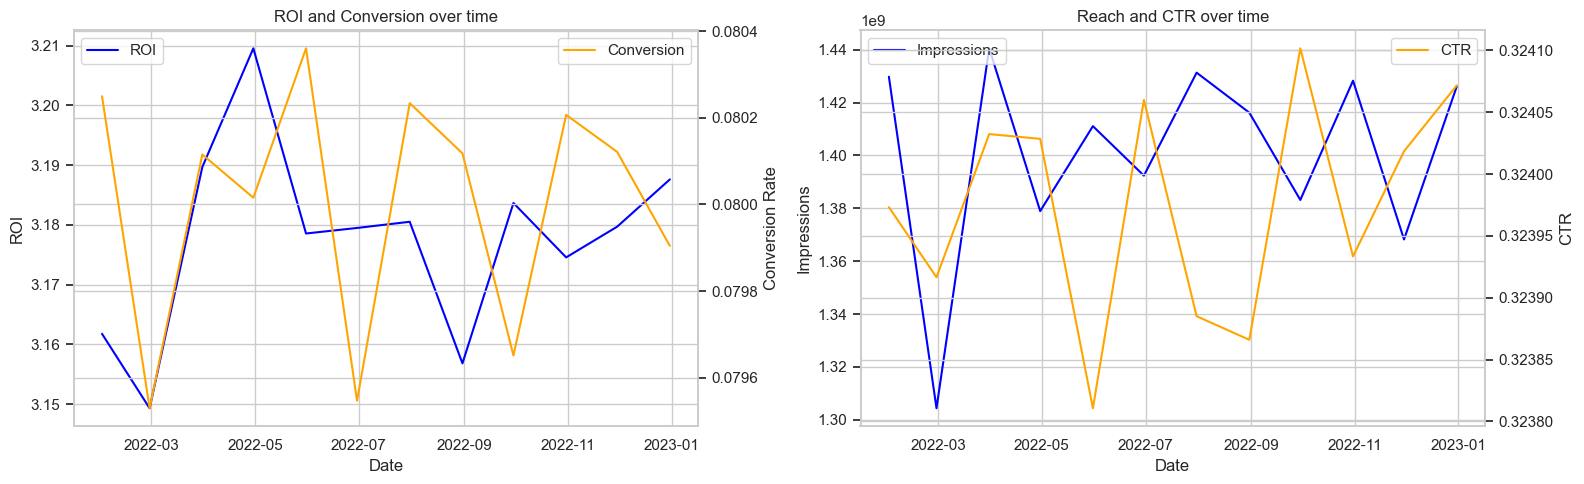

In [28]:
# ==== 1. Агрегация по месяцам ====
monthly = (
    df_ml
    .set_index("Date")
    .resample("M")
    .agg({
        "ROI": "mean",
        "Conversion_Rate": "mean",
        "Impressions": "sum",
        "Clicks": "sum",
    })
    .reset_index()
)

# CTR
monthly["CTR"] = monthly["Clicks"] / monthly["Impressions"]

# ==== 2. Графики с двумя осями ====
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# --- LEFT: ROI vs Conversion ---
ax1 = axes[0]
ax2 = ax1.twinx()

sns.lineplot(data=monthly, x="Date", y="ROI", ax=ax1, label="ROI", color="blue")
sns.lineplot(data=monthly, x="Date", y="Conversion_Rate", ax=ax2, label="Conversion", color="orange")

ax1.set_title("ROI and Conversion over time")
ax1.set_ylabel("ROI")
ax2.set_ylabel("Conversion Rate")

ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

# --- RIGHT: Impressions vs CTR ---
ax3 = axes[1]
ax4 = ax3.twinx()

sns.lineplot(data=monthly, x="Date", y="Impressions", ax=ax3, label="Impressions", color="blue")
sns.lineplot(data=monthly, x="Date", y="CTR", ax=ax4, label="CTR", color="orange")

ax3.set_title("Reach and CTR over time")
ax3.set_ylabel("Impressions")
ax4.set_ylabel("CTR")

ax3.legend(loc="upper left")
ax4.legend(loc="upper right")

plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "monthly_rois_and_ctr.png"), dpi=300, bbox_inches="tight")
plt.show()


In [29]:
# AI-driven channel ranking by effectiveness
# Builds an effectiveness score per channel using predicted ROI and conversion rate
# - input: df_ml with ROI_pred
# - output: channel_rank table sorted by score (best channels on top)

# AI: channel ranking (effectiveness score)
def rank_channels(df_in):
    agg = (
        df_in.groupby("Channel_Used")
        .agg(
            ROI_actual=("ROI", "mean"),
            ROI_pred=("ROI_pred", "mean"),
            Conversion_Rate=("Conversion_Rate", "mean"),
            Acquisition_Cost=("Acquisition_Cost", "median"),
            Impressions=("Impressions", "sum"),
            Clicks=("Clicks", "sum"),
        )
        .reset_index()
    )
    agg["CTR"] = agg["Clicks"] / agg["Impressions"]
    agg["score"] = agg["ROI_pred"] * agg["Conversion_Rate"].clip(lower=0)
    return agg.sort_values("score", ascending=False)

channel_rank = rank_channels(df_ml)
channel_rank.head(10)

,Channel_Used,ROI_actual,ROI_pred,Conversion_Rate,Acquisition_Cost,Impressions,Clicks,CTR,score
3,Twitter,4.002,3.358,0.080,"7,795.300",4603219796,1515770057,0.329,0.270
1,Instagram,4.009,3.358,0.080,"7,713.380",4602504047,1515298729,0.329,0.268
0,Facebook,3.987,3.343,0.080,"7,743.150",4617307456,1520264076,0.329,0.267
2,Pinterest,0.716,0.669,0.080,"7,778.500",2987239617,894768249,0.300,0.054


In [30]:
# AI: ROI forecast by channel
# Uses the trained ROI model to estimate expected ROI for each channel
# under typical (median/mode) campaign conditions.
# - input: roi_model, med_vals (median numeric features), mode_vals (mode categorical features)
# - output: dataframe with Channel_Used and ROI_forecast sorted by forecast (best channels on top)

# AI: ROI forecast by channel using the model
roi_model = models["ROI"]
mode_vals = {c: df_ml[c].mode()[0] for c in cat_cols}
med_vals = df_ml.median(numeric_only=True)


def forecast_roi_by_channel(channels=None):
    channels = channels or sorted(df_ml["Channel_Used"].unique())
    rows = []
    for ch in channels:
        row = {
            "Impressions": med_vals["Impressions"],
            "Clicks": med_vals["Clicks"],
            "Engagement_Score": med_vals["Engagement_Score"],
            "Acquisition_Cost": med_vals["Acquisition_Cost"],
            "Conversion_Rate": med_vals["Conversion_Rate"],
            "Duration_days": med_vals.get("Duration_days", 0),
            "Channel_Used": ch,
            "Target_Audience": mode_vals["Target_Audience"],
            "Customer_Segment": mode_vals["Customer_Segment"],
            "Location": mode_vals["Location"],
            "Language": mode_vals["Language"],
        }
        rows.append(row)
    df_scenarios = pd.DataFrame(rows)
    df_scenarios["ROI_forecast"] = predict_model(roi_model, df_scenarios)
    return df_scenarios[["Channel_Used", "ROI_forecast"]].sort_values("ROI_forecast", ascending=False)


forecast_roi_by_channel()

,Channel_Used,ROI_forecast
1,Instagram,3.342
3,Twitter,3.342
0,Facebook,3.321
2,Pinterest,0.670


C:\Users\User\AppData\Local\Temp\ipykernel_6044\3660013049.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


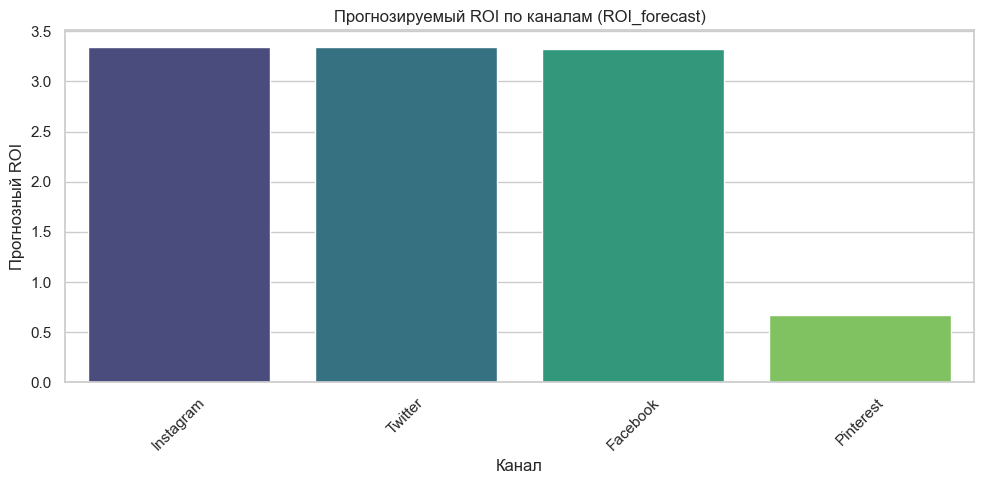

In [31]:
# Визуализация прогноза ROI по каналам
df_forecast = forecast_roi_by_channel()

plt.figure(figsize=(10, 5))
sns.barplot(
    data=df_forecast,
    x="Channel_Used",
    y="ROI_forecast",
    palette="viridis"
)
plt.title("Прогнозируемый ROI по каналам (ROI_forecast)")
plt.xlabel("Канал")
plt.ylabel("Прогнозный ROI")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "roi_forecast_by_channel.png"), dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
# AI-based media budget recommendation
# Distributes total budget across top-performing channels based on the AI effectiveness score.
# - input: channel_rank and user-defined total_budget
# - output: budget_plan table with recommended spend per channel

# AI: budget recommendation

balance = 100000 # INPUUUT total budget

def recommend_budget(total_budget, min_share=0.05, top_n=4):
    base = channel_rank.head(top_n).copy()

    # добавляем значения ROI_forecast из df_scenarios
    df_scenarios = forecast_roi_by_channel(channels=base["Channel_Used"].tolist())
    base = base.merge(df_scenarios[["Channel_Used", "ROI_forecast"]], on="Channel_Used", how="left")

    weights = base["score"].clip(lower=0)
    weights = weights / weights.sum()
    weights = np.maximum(weights, min_share)
    weights = weights / weights.sum()
    base["recommended_budget"] = (weights * total_budget).round(2)
    return base[["Channel_Used", "ROI_pred",  "Acquisition_Cost", "recommended_budget"]]

budget_plan = recommend_budget(balance)
budget_plan

,Channel_Used,ROI_pred,ROI_forecast,Acquisition_Cost,recommended_budget
0,Twitter,3.358,3.342,"7,795.300","31,441.150"
1,Instagram,3.358,3.342,"7,713.380","31,207.600"
2,Facebook,3.343,3.321,"7,743.150","31,114.650"
3,Pinterest,0.669,0.670,"7,778.500","6,236.610"


In [34]:
channel_cost_conv = (
    df_ml.groupby("Channel_Used")[["Acquisition_Cost", "Conversion_Rate", "ROI"]]
    .mean()
    .reset_index()
    .sort_values("Conversion_Rate", ascending=False)
)
channel_cost_conv.to_csv(os.path.join(OUT_DIR, "channel_cost_conv.csv"), index=False)

channel_cost_conv.head(10)

,Channel_Used,Acquisition_Cost,Conversion_Rate,ROI
3,Twitter,"7,774.122",0.080,4.002
2,Pinterest,"7,769.739",0.080,0.716
0,Facebook,"7,745.023",0.080,3.987
1,Instagram,"7,726.253",0.080,4.009


In [36]:
budget_plan

,Channel_Used,ROI_pred,ROI_forecast,Acquisition_Cost,recommended_budget
0,Twitter,3.358,3.342,"7,795.300","31,441.150"
1,Instagram,3.358,3.342,"7,713.380","31,207.600"
2,Facebook,3.343,3.321,"7,743.150","31,114.650"
3,Pinterest,0.669,0.670,"7,778.500","6,236.610"
